# Linear Decoding

## Imports & Configuration

In [1]:
import torch, torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from scipy.stats import pearsonr, ttest_1samp, ttest_rel
from skimage.metrics import structural_similarity as ssim

/tmp/ipykernel_65/3000011943.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
cd ..

/home/jovyan/work/SensoriumDecoding


In [3]:
from src.utils.data import load_args
from src.utils.data import get_training_ds
from src.utils.data import get_datasets

In [4]:
class Args:
    def __init__(self):
        self.device = torch.device("cpu")
        self.output_dir = "runs/ridge_reg/"
args = Args()
load_args(args)

In [5]:
train_ds, val_ds, test_ds = get_training_ds(
    args,
    data_dir=args.dataset,
    mouse_ids=args.mouse_ids,
    batch_size=args.batch_size,
    device=args.device,
)

## Decoding

In [6]:
def reshape_to_original(image_flat):
    return image_flat.reshape((args.target_size[0], args.target_size[1]))

In [7]:
def explained_variance_paper(y, y_hat):
    # Calculate the variance of the actual response for each voxel
    var_y = np.var(y, axis=0)
    
    # Calculate the variance of the residuals for each voxel
    var_residuals = np.var(y - y_hat, axis=0)
    
    # Calculate the explained variance for each voxel
    explained_variances = (var_y - var_residuals) / var_y
    
    return explained_variances

In [8]:
def calculate_ssim(X_test, X_test_pred):
    # Reshape to original image shape
    X_test = X_test.reshape(-1, args.target_size[0], args.target_size[1])
    X_test_pred = X_test_pred.reshape(-1, args.target_size[0], args.target_size[1])

    # Initialize list to store SSIM values
    ssim_values = []

    # Calculate SSIM for each sample
    for i in range(X_test.shape[0]):
        ssim_value = ssim(X_test[i], X_test_pred[i], data_range=X_test[i].max() - X_test[i].min())
        ssim_values.append(ssim_value)

    # Return average SSIM
    return np.mean(ssim_values)

In [9]:
def plot_correlations(correlations):
    plt.hist(correlations, bins=200, range=(-1.1, 1.1), color='blue', alpha=0.7)

In [10]:
def get_data(mouse):
    # Train data
    X_train, y_train, behaviour_train = [], [], []
    for i, batch in enumerate(train_ds[mouse]):
        X_train_batch = np.array([sample.flatten().numpy() for sample in batch['image']])
        y_train_batch = np.array([sample.flatten().numpy() for sample in batch['response']])
        behaviour_batch = np.array([sample.flatten().numpy() for sample in batch['behavior']])
        pupil_batch = np.array([sample.flatten().numpy() for sample in batch['pupil_center']])
        X_train.extend(X_train_batch)
        y_train.extend(y_train_batch)
        behaviour_train.extend(np.concatenate((behaviour_batch, pupil_batch), axis=1))
    y_train = np.array(y_train) / np.sqrt(len(y_train))
    behaviour_train = np.array(behaviour_train) / np.sqrt(len(y_train))

    # Test data
    X_test, y_test, behaviour_test = [], [], []
    for i, batch in enumerate(test_ds[mouse]):
        X_test_batch = np.array([sample.flatten().numpy() for sample in batch['image']])
        y_test_batch = np.array([sample.flatten().numpy() for sample in batch['response']])
        behaviour_batch = np.array([sample.flatten().numpy() for sample in batch['behavior']])
        pupil_batch = np.array([sample.flatten().numpy() for sample in batch['pupil_center']])
        X_test.extend(X_test_batch)
        y_test.extend(y_test_batch)
        behaviour_test.extend(np.concatenate((behaviour_batch, pupil_batch), axis=1))
    y_test = np.array(y_test) / np.sqrt(len(y_train))
    behaviour_test = np.array(behaviour_test) / np.sqrt(len(y_train))

    return X_train, y_train, behaviour_train, X_test, y_test, behaviour_test

In [12]:
def result(X_train, y_train, behaviour_train, X_test, y_test, behaviour_test, with_behaviour=True):
    model = RidgeCV(alphas=[1000, 5000, 8000, 10000, 20000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000], scoring='r2', alpha_per_target=True)
    neurons = len(y_train[0])
    if with_behaviour:
        y_train = np.concatenate((y_train, np.array(behaviour_train)), axis=1)
        y_test = np.concatenate((y_test, np.array(behaviour_test)), axis=1)
    model.fit(X_train, y_train)
    print(f"Min alpha: {min(model.alpha_)}, Max alpha: {max(model.alpha_)}")

    X_test = np.array(X_test)
    y_pred = np.array(model.predict(X_test))
    explained_variance = explained_variance_paper(y_test, y_pred)
    m = 2500
    top_voxel_indices = np.argsort(explained_variance)[::-1][:m]
    B = (model.coef_[top_voxel_indices, :])
    if with_behaviour:
        B_behaviors = model.coef_[neurons:, :]
        B = np.concatenate((B, B_behaviors), axis=0)
    print(f"B shape: {B.shape}")

    y_test_selected = np.array(y_test)[:, top_voxel_indices]
    if with_behaviour:
        y_test_selected = np.concatenate((y_test_selected, behaviour_test), axis=1)

    R = np.cov(np.array(X_train), rowvar=False)
    print(f"R shape {R.shape}")
    
    y_pred_train = np.array(model.predict(X_train))
    if with_behaviour:
        y_train = np.concatenate((y_train[:, top_voxel_indices], y_train[:, neurons:]), axis=1)
        y_pred_train = np.concatenate((y_pred_train[:, top_voxel_indices], y_pred_train[:, neurons:]), axis=1)
    else:
        y_train = y_train[:, top_voxel_indices]
        y_pred_train = y_pred_train[:, top_voxel_indices]
    residuals_train = y_train - y_pred_train
    Sigma = np.diag(np.var(residuals_train, axis=0))
    print(f"Sigma shape: {Sigma.shape}")

    term1 = R - R @ B.T @ np.linalg.inv(Sigma + B @ R @ B.T) @ B @ R
    term2 = B.T @ np.linalg.inv(Sigma)

    del R, B
    print(f"term1 shape: {term1.shape}")
    print(f"term2 shape: {term2.shape}")

    X_test_pred = term1 @ term2 @ y_test_selected.T
    del term1, term2, y_test_selected
    print(f"X_test_pred shape: {(X_test_pred.T).shape}")

    return X_test, X_test_pred

## With Behaviour

In [13]:
mouse_ids = ['A', 'B', 'C', 'D', 'E']
results = {}
for idx, mouse in enumerate(mouse_ids):
    X_train, y_train, behaviour_train, X_test, y_test, behaviour_test = get_data(mouse)
    X_test, X_test_pred = result(X_train, y_train, behaviour_train, X_test, y_test, behaviour_test, with_behaviour=True)
    results[mouse] = (X_test, X_test_pred)

Min alpha: 5000, Max alpha: 110000
B shape: (2505, 2304)
R shape (2304, 2304)
Sigma shape: (2505, 2505)
term1 shape: (2304, 2304)
term2 shape: (2304, 2505)
X_test_pred shape: (998, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2505, 2304)
R shape (2304, 2304)
Sigma shape: (2505, 2505)
term1 shape: (2304, 2304)
term2 shape: (2304, 2505)
X_test_pred shape: (999, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2505, 2304)
R shape (2304, 2304)
Sigma shape: (2505, 2505)
term1 shape: (2304, 2304)
term2 shape: (2304, 2505)
X_test_pred shape: (989, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2505, 2304)
R shape (2304, 2304)
Sigma shape: (2505, 2505)
term1 shape: (2304, 2304)
term2 shape: (2304, 2505)
X_test_pred shape: (993, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2505, 2304)
R shape (2304, 2304)
Sigma shape: (2505, 2505)
term1 shape: (2304, 2304)
term2 shape: (2304, 2505)
X_test_pred shape: (994, 2304)


Average pixel correlation: 0.3891821628248227
Average sample correlation: -0.004295907571430868
Average SSIM: 0.00012000039736341267
Best sample correlation: 0.5195382345167365
Average pixel correlation: 0.3854625583597478
Average sample correlation: 0.04638433356192742
Average SSIM: 2.455228122198665e-05
Best sample correlation: 0.5832705317766324
Average pixel correlation: 0.3906648156729269
Average sample correlation: -0.01228541054834945
Average SSIM: -8.406967420241992e-06
Best sample correlation: 0.4738979372069549
Average pixel correlation: 0.47502688842549506
Average sample correlation: 0.03244815654515031
Average SSIM: -1.994426778342376e-05
Best sample correlation: 0.4926978690554136
Average pixel correlation: 0.41161986130162487
Average sample correlation: -0.05705003944345461
Average SSIM: -1.2188383362402854e-05
Best sample correlation: 0.6727979371126018
Average pixel correlations: 0.4103912573169234
Average SSIM: 2.080261200386614e-05
Significance test for mouse A: t = 1

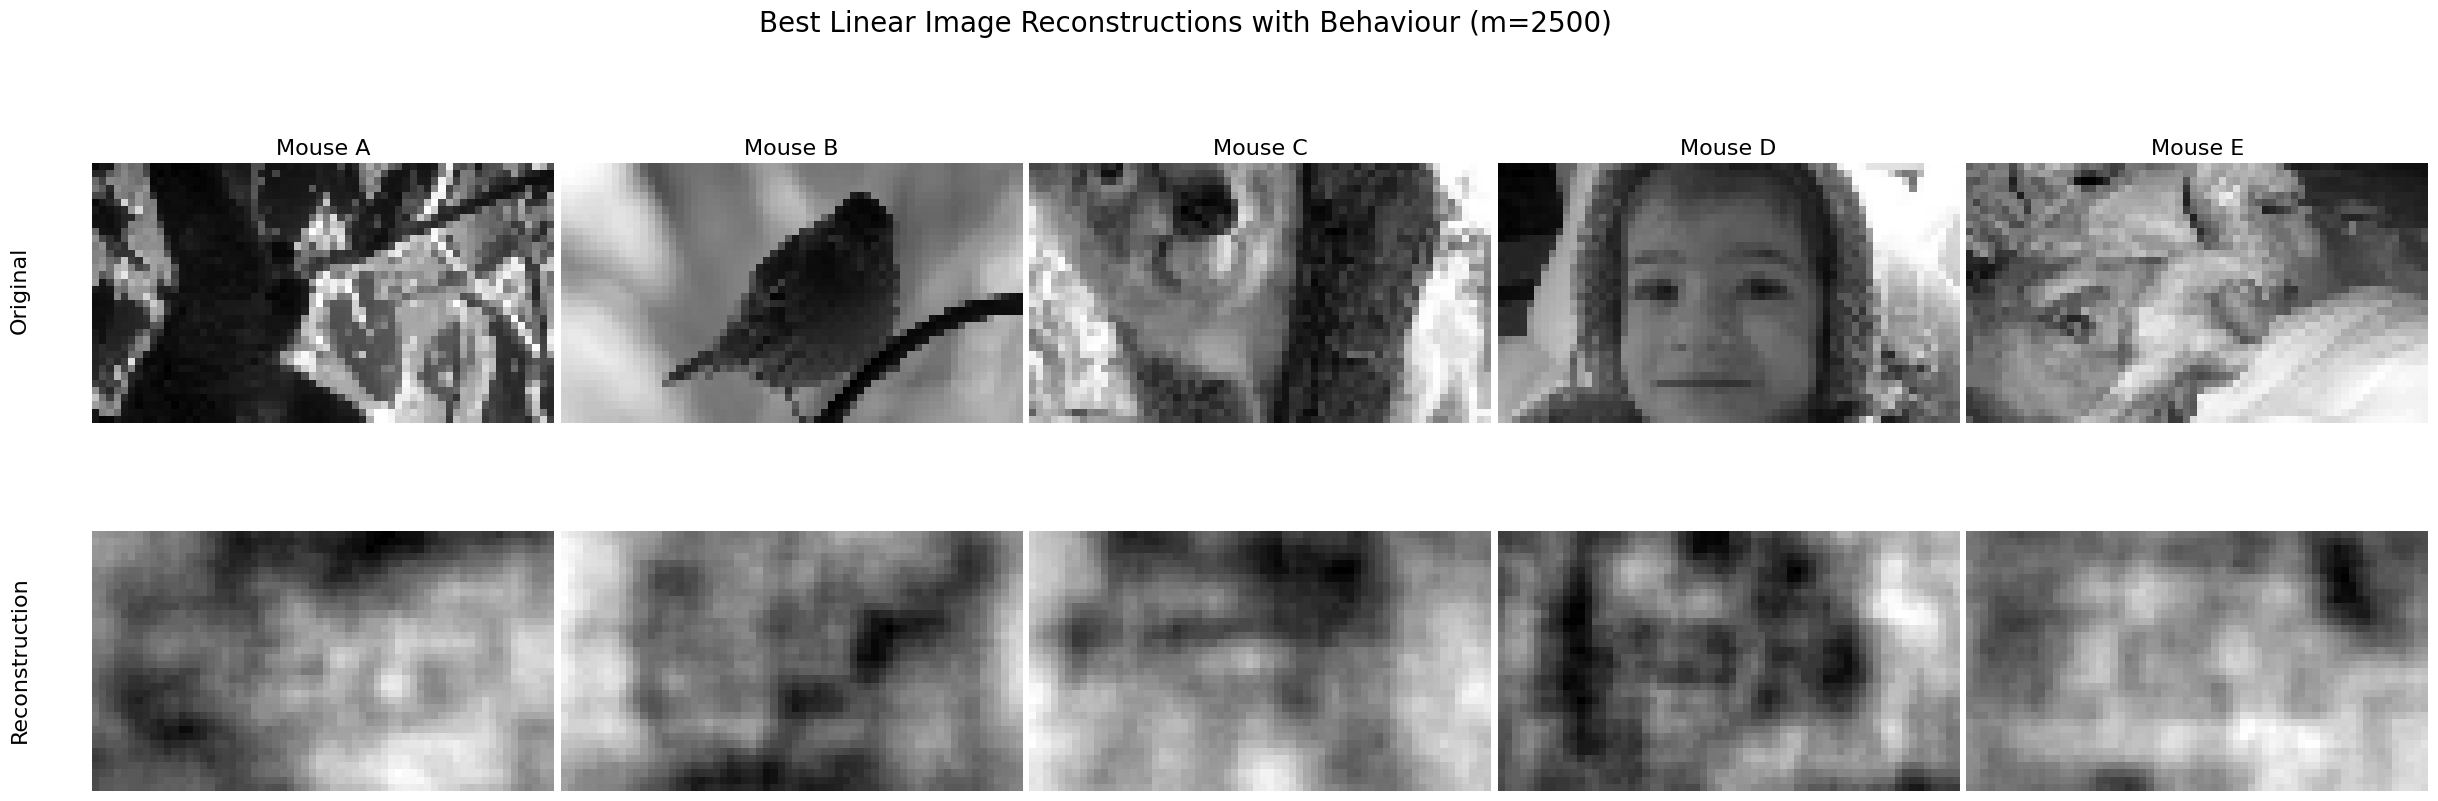

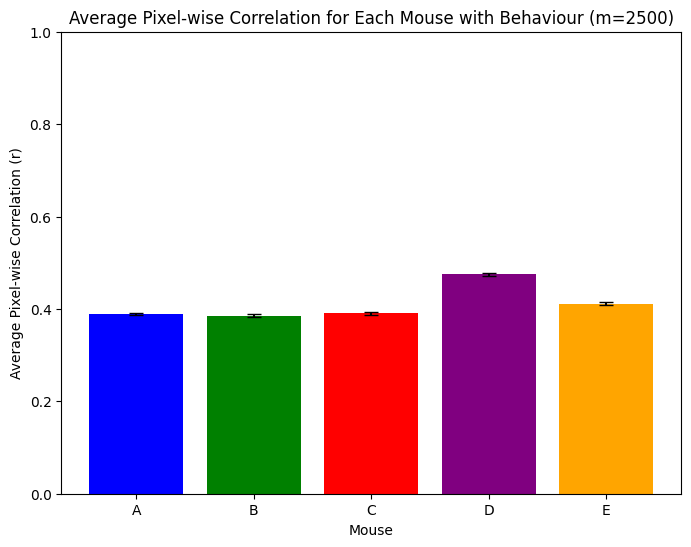

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig2, axes2 = plt.subplots(figsize=(8, 6))
for ax in axes.flatten():
    ax.axis('off')
correlations_behaviour = {}
average_correlations = []
std_error = []
significance = {}
average_ssim = []
data = {'Mouse': [], 'Average Pixel Correlation': [], 'Average SSIM': []}
for idx, mouse in enumerate(mouse_ids):
    X_test, X_test_pred = results[mouse]
    X_test_pred = X_test_pred.T
    # Pixel correlations
    pixel_correlations = [pearsonr(X_test[:, i], X_test_pred[:, i])[0] for i in range(X_test.shape[1])]
    correlations_behaviour[mouse] = pixel_correlations
    print("Average pixel correlation:", np.mean(pixel_correlations))
    average_correlations.append(np.mean(pixel_correlations))

    significance[mouse] = ttest_1samp(pixel_correlations, 0)

    std_error.append(np.std(pixel_correlations) / np.sqrt(len(pixel_correlations)))

    sample_correlations = [pearsonr(X_test[i, :], X_test_pred[i, :])[0] for i in range(X_test.shape[0])]
    print("Average sample correlation:", np.mean(sample_correlations))

    avg_ssim = calculate_ssim(X_test, X_test_pred)
    print("Average SSIM:", avg_ssim)
    average_ssim.append(avg_ssim)

    data['Mouse'].append(mouse)
    data['Average Pixel Correlation'].append(np.mean(pixel_correlations))
    data['Average SSIM'].append(avg_ssim)

    best_index = np.argmax(sample_correlations)
    print("Best sample correlation:", sample_correlations[best_index])

    # Image reconstruction examples
    original = reshape_to_original(X_test[best_index])
    reconstructed = reshape_to_original(X_test_pred[best_index])

    # Plot the original image
    axes[0, idx].imshow(original, cmap='gray')
    axes[0, idx].set_title(f'Mouse {mouse}')

    # Plot the reconstructed image
    axes[1, idx].imshow(reconstructed, cmap='gray')

print("Average pixel correlations:", np.mean(average_correlations))
print("Average SSIM:", np.mean(average_ssim))
data = pd.DataFrame(data)
data.to_csv("output/m_2500_with_behaviour/linear_reconstruction_metrics.csv", index=False)
for mouse in mouse_ids:
    t_val, p_val = significance[mouse]
    print(f"Significance test for mouse {mouse}: t = {t_val}, p = {p_val}")

# Add titles for each column
for i, mouse in enumerate(['A', 'B', 'C', 'D', 'E']):
    axes[0, i].set_title(f'Mouse {mouse}', fontsize=16)

# Add titles for each row
fig.text(0.03, 0.70, 'Original', va='center', rotation='vertical', fontsize=16)
fig.text(0.03, 0.33, 'Reconstruction', va='center', rotation='vertical', fontsize=16)

# Add figure title
fig.suptitle('Best Linear Image Reconstructions with Behaviour (m=2500)', fontsize=20)

fig.tight_layout(rect=[0.06, 0.06, 1, 1], pad=0.5, h_pad=0.5, w_pad=0.5)

# Bar plot of average pixel correlations
axes2.bar(mouse_ids, average_correlations, yerr=std_error, color=['blue', 'green', 'red', 'purple', 'orange'], capsize=5)
axes2.set_xlabel('Mouse')
axes2.set_ylabel('Average Pixel-wise Correlation (r)')
axes2.set_title('Average Pixel-wise Correlation for Each Mouse with Behaviour (m=2500)')
axes2.set_ylim([0, 1])

plt.show()
fig.savefig("figures/linear/with_behaviour/linear_reconstructions.png")
fig2.savefig("figures/linear/with_behaviour/average_pixel_correlations.png")

## Without Behaviour

In [15]:
mouse_ids = ['A', 'B', 'C', 'D', 'E']
results = {}
for idx, mouse in enumerate(mouse_ids):
    X_train, y_train, behaviour_train, X_test, y_test, behaviour_test = get_data(mouse)
    X_test, X_test_pred = result(X_train, y_train, behaviour_train, X_test, y_test, behaviour_test, with_behaviour=False)
    results[mouse] = (X_test, X_test_pred)

Min alpha: 5000, Max alpha: 110000
B shape: (2500, 2304)
R shape (2304, 2304)
Sigma shape: (2500, 2500)
term1 shape: (2304, 2304)
term2 shape: (2304, 2500)
X_test_pred shape: (998, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2500, 2304)
R shape (2304, 2304)
Sigma shape: (2500, 2500)
term1 shape: (2304, 2304)
term2 shape: (2304, 2500)
X_test_pred shape: (999, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2500, 2304)
R shape (2304, 2304)
Sigma shape: (2500, 2500)
term1 shape: (2304, 2304)
term2 shape: (2304, 2500)
X_test_pred shape: (989, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2500, 2304)
R shape (2304, 2304)
Sigma shape: (2500, 2500)
term1 shape: (2304, 2304)
term2 shape: (2304, 2500)
X_test_pred shape: (993, 2304)
Min alpha: 5000, Max alpha: 110000
B shape: (2500, 2304)
R shape (2304, 2304)
Sigma shape: (2500, 2500)
term1 shape: (2304, 2304)
term2 shape: (2304, 2500)
X_test_pred shape: (994, 2304)


Average pixel correlation: 0.38738093848875177
Average sample correlation: -0.004393189662839329
Average SSIM: 0.00012532576950517542
Best sample correlation: 0.517285203174417
Average pixel correlation: 0.3821931387967573
Average sample correlation: 0.04578774529268503
Average SSIM: 2.3746335545787844e-05
Best sample correlation: 0.5976566432493966
Average pixel correlation: 0.38507166698018197
Average sample correlation: -0.007809036497777876
Average SSIM: 9.657329562108692e-08
Best sample correlation: 0.48125101491635364
Average pixel correlation: 0.47404194181324066
Average sample correlation: 0.03157153880429873
Average SSIM: -2.007093210103228e-05
Best sample correlation: 0.4861609482110364
Average pixel correlation: 0.40943178685515247
Average sample correlation: -0.057615375975133054
Average SSIM: -5.222102880951141e-06
Best sample correlation: 0.6711182572367228
Average pixel correlations: 0.4076238945868168
Average SSIM: 2.477512867292019e-05
Significance test for mouse A: t 

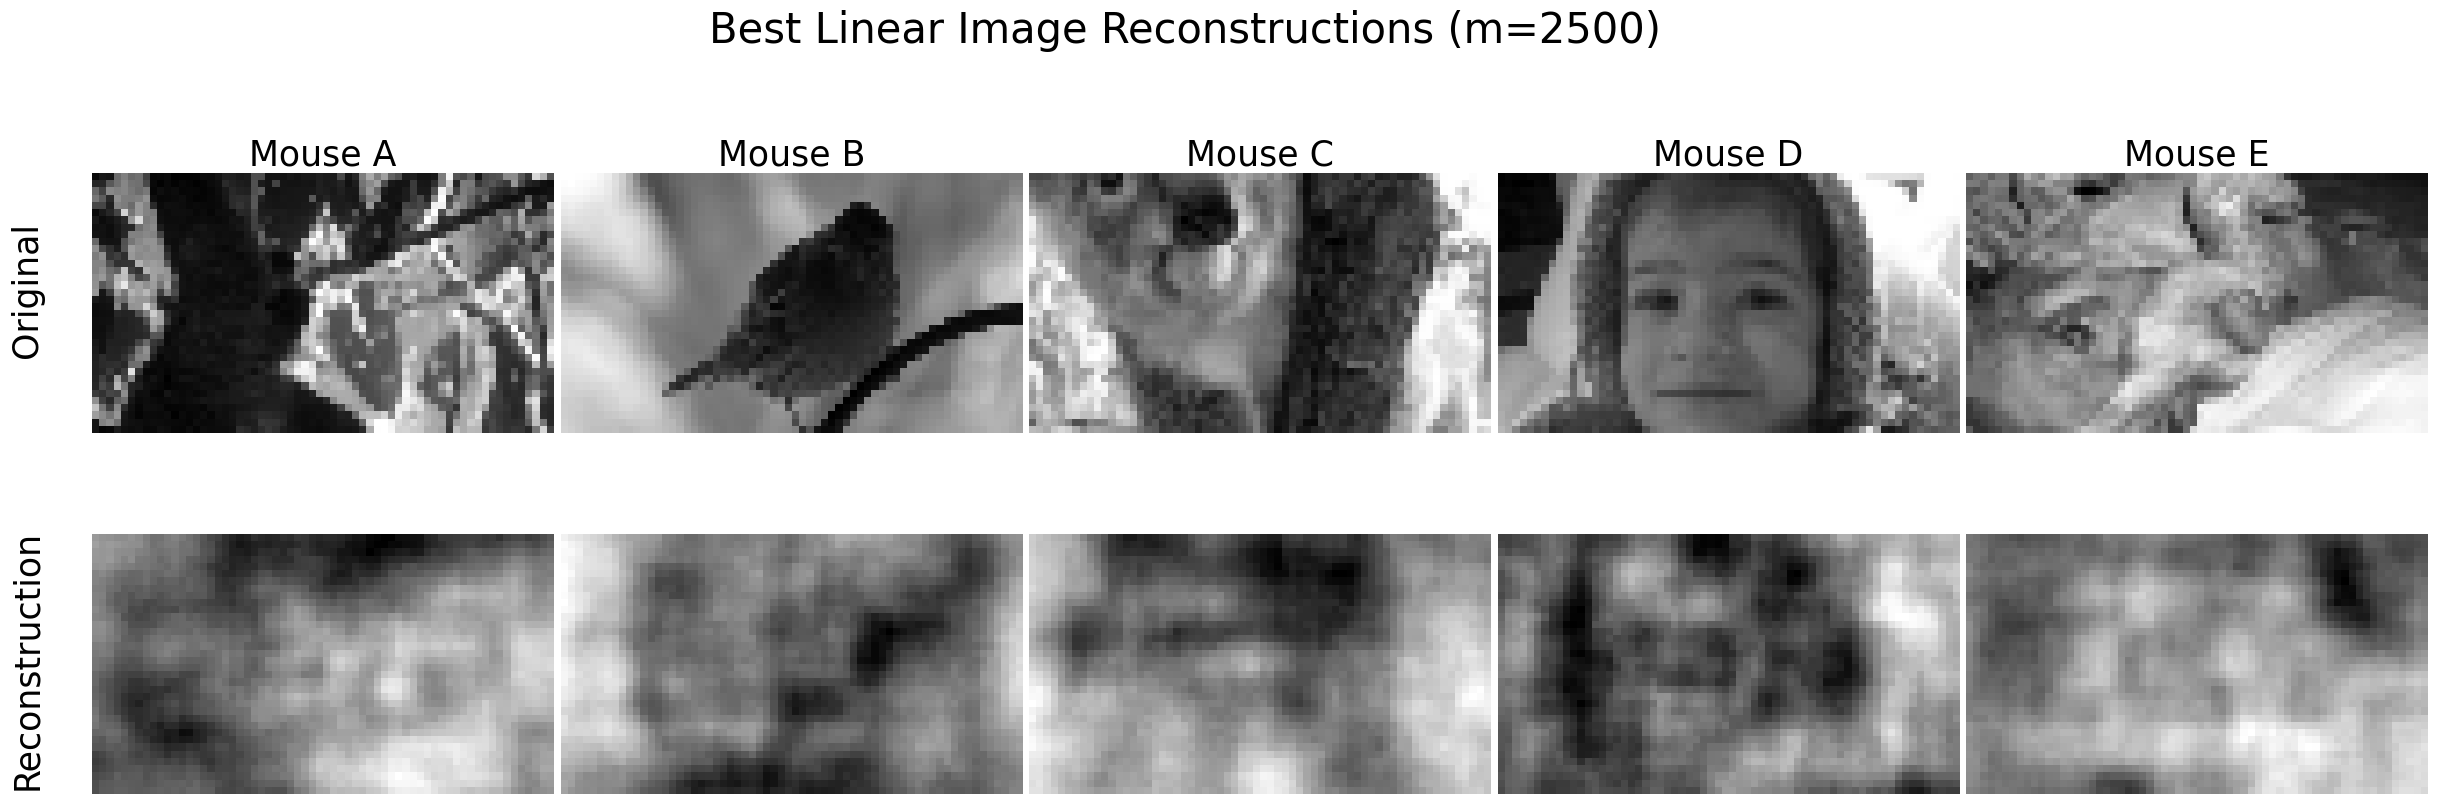

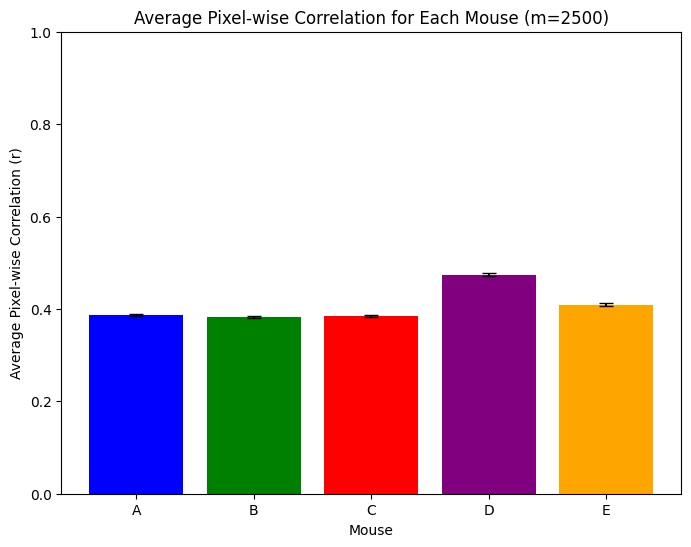

In [20]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10))
fig2, axes2 = plt.subplots(figsize=(8, 6))
for ax in axes.flatten():
    ax.axis('off')
correlations = {}
average_correlations = []
std_error = []
significance = {}
average_ssim = []
data = {'Mouse': [], 'Average Pixel Correlation': [], 'Average SSIM': []}
for idx, mouse in enumerate(mouse_ids):
    X_test, X_test_pred = results[mouse]
    X_test_pred = X_test_pred.T
    # Pixel correlations
    pixel_correlations = [pearsonr(X_test[:, i], X_test_pred[:, i])[0] for i in range(X_test.shape[1])]
    correlations[mouse] = pixel_correlations
    print("Average pixel correlation:", np.mean(pixel_correlations))
    average_correlations.append(np.mean(pixel_correlations))

    significance[mouse] = ttest_1samp(pixel_correlations, 0)

    std_error.append(np.std(pixel_correlations) / np.sqrt(len(pixel_correlations)))

    sample_correlations = [pearsonr(X_test[i, :], X_test_pred[i, :])[0] for i in range(X_test.shape[0])]
    print("Average sample correlation:", np.mean(sample_correlations))

    avg_ssim = calculate_ssim(X_test, X_test_pred)
    print("Average SSIM:", avg_ssim)
    average_ssim.append(avg_ssim)

    data['Mouse'].append(mouse)
    data['Average Pixel Correlation'].append(np.mean(pixel_correlations))
    data['Average SSIM'].append(avg_ssim)

    best_index = np.argmax(sample_correlations)
    print("Best sample correlation:", sample_correlations[best_index])

    # Image reconstruction examples
    original = reshape_to_original(X_test[best_index])
    reconstructed = reshape_to_original(X_test_pred[best_index])

    # Plot the original image
    axes[0, idx].imshow(original, cmap='gray')
    axes[0, idx].set_title(f'Mouse {mouse}')

    # Plot the reconstructed image
    axes[1, idx].imshow(reconstructed, cmap='gray')

print("Average pixel correlations:", np.mean(average_correlations))
print("Average SSIM:", np.mean(average_ssim))
data = pd.DataFrame(data)
data.to_csv("output/downsampled/m_2500/linear_reconstruction_metrics.csv", index=False)
for mouse in mouse_ids:
    t_val, p_val = significance[mouse]
    print(f"Significance test for mouse {mouse}: t = {t_val}, p = {p_val}")

# Add titles for each column
for i, mouse in enumerate(['A', 'B', 'C', 'D', 'E']):
    axes[0, i].set_title(f'Mouse {mouse}', fontsize=25)

# Add titles for each row
fig.text(0.03, 0.70, 'Original', va='center', rotation='vertical', fontsize=25)
fig.text(0.03, 0.33, 'Reconstruction', va='center', rotation='vertical', fontsize=25)

# Add figure title
fig.suptitle('Best Linear Image Reconstructions (m=2500)', fontsize=30)

fig.tight_layout(rect=[0.06, 0.06, 1, 1], pad=0.5, h_pad=0.5, w_pad=0.5)

# Bar plot of average pixel correlations
axes2.bar(mouse_ids, average_correlations, yerr=std_error, color=['blue', 'green', 'red', 'purple', 'orange'], capsize=5)
axes2.set_xlabel('Mouse')
axes2.set_ylabel('Average Pixel-wise Correlation (r)')
axes2.set_title('Average Pixel-wise Correlation for Each Mouse (m=2500)')
axes2.set_ylim([0, 1])

plt.show()
fig.savefig("figures/linear/downsampled/best_reconstructions_m_2500/linear_reconstructions.png")
fig2.savefig("figures/linear/downsampled/best_reconstructions_m_2500/average_pixel_correlations.png")

## Comparison

In [18]:
# Perform paired t-test for each mouse and print p-values
differences = []
p_values = []
for mouse in correlations.keys():
    correlations_list = correlations[mouse]
    correlations_with_behaviour_list = correlations_behaviour[mouse]
    _, p_value = ttest_rel(correlations_with_behaviour_list, correlations_list)
    difference = np.mean(correlations_with_behaviour_list) - np.mean(correlations_list)
    differences.append(difference)
    p_values.append(p_value)
    print(f"Mouse {mouse}: p-value = {p_value}, delta = {difference}")

average_difference = np.mean(differences)
average_p_value = np.mean(p_values)
print(f"Average difference in correlation: {average_difference}")
print(f"Average p-value: {average_p_value}")


Mouse A: p-value = 0.0, delta = 0.001801224336070939
Mouse B: p-value = 0.0, delta = 0.003269419562990483
Mouse C: p-value = 0.0, delta = 0.005593148692744909
Mouse D: p-value = 0.0, delta = 0.0009849466122544004
Mouse E: p-value = 0.0, delta = 0.002188074446472399
Average difference in correlation: 0.002767362730106626
Average p-value: 0.0
